# Sparse GP benchmarks

Sparse GP benchmarks for 'Kernels with Latent Gaussian Processes for Non-stationary Regression' paper.
Here we train and evaluate GPs with the following kernels
- Squared exponemtial
- Squared exponemtial times periodic plus squared exponential (custom kernel)

In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [3]:
import urllib.request
import os
import numpy as np
from math import floor
import pandas as pd

In [4]:
import sgpr as sgpr

# Load data

In [5]:
data_df = pd.read_csv('khyber_2000_2010_tp.csv')

In [6]:
data = torch.Tensor(data_df.values)
X = data[:, 1:-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

In [7]:
train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [8]:
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [9]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [59]:
##### Inducing points
# random
z_init = np.random.random(size=(1900,3)) * 2 -1
Z_init = torch.Tensor(z_init).contiguous()

## Sparse GP 

In [108]:
# Kernels
SE_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
custom_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2, active_dims=[1,2]) + gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[0])* gpytorch.kernels.PeriodicKernel(active_dims=[0]))

In [109]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = sgpr.SparseGPR(train_x, train_y, likelihood, Z_init, custom_kernel)
model.likelihood.noise = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

In [110]:
# Train:
losses = model.train_model(optimizer, max_steps=100)

/home/users/ktazi/.local/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/users/ktazi/.local/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/users/ktazi/.local/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Iter 1/100 - Loss: 19978.984   outputscale: 0.693  lengthscale: None   noise: 0.000 
Iter 11/100 - Loss: 18610.373   outputscale: 0.741  lengthscale: None   noise: 0.000 
Iter 21/100 - Loss: 18168.639   outputscale: 0.778  lengthscale: None   noise: 0.000 
Iter 31/100 - Loss: 17633.850   outputscale: 0.814  lengthscale: None   noise: 0.000 
Iter 41/100 - Loss: 16839.408   outputscale: 0.861  lengthscale: None   noise: 0.000 
Iter 51/100 - Loss: 16100.063   outputscale: 0.917  lengthscale: None   noise: 0.000 
Iter 61/100 - Loss: 14275.843   outputscale: 0.984  lengthscale: None   noise: 0.000 
Iter 71/100 - Loss: 12807.038   outputscale: 1.052  lengthscale: None   noise: 0.000 
Iter 81/100 - Loss: 11972.965   outputscale: 1.110  lengthscale: None   noise: 0.000 
Iter 91/100 - Loss: 10986.381   outputscale: 1.165  lengthscale: None   noise: 0.000 


## Metrics

In [111]:
import matplotlib.pyplot as plt

In [112]:
from metrics import rmse, nlpd

In [113]:
## predictions
test_pred = model.posterior_predictive(test_x)
y_std = torch.tensor([1.0]) ## did not scale y-values

In [114]:
rmse_test = np.round(rmse(test_pred.loc, test_y, y_std).item(), 4)
nlpd_test = np.round(nlpd(test_pred, test_y, y_std).item(), 4)

/home/users/ktazi/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1390.8875732421875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [115]:
nlpd_test

12636.3799

In [95]:
rmse_test

13.9471

In [96]:
d = test_x[19:]

In [97]:
a = test_y[19:]

In [98]:
pred = model.posterior_predictive(d[::43])

In [99]:
## predictions
train_pred = model.posterior_predictive(train_x)
y_std = torch.tensor([1.0]) ## did not scale y-values

/home/users/ktazi/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


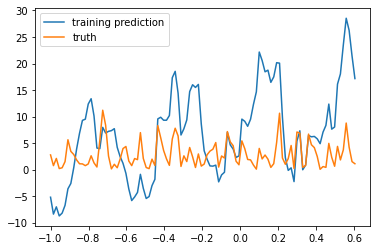

In [100]:
plt.plot(train_x[::43, 0], train_pred.loc[::43], label='training prediction')
plt.plot(train_x[::43, 0], train_y[::43], label='truth')
plt.legend()

In [101]:
pred.loc.shape

torch.Size([26])

In [102]:
d.shape

torch.Size([1117, 3])

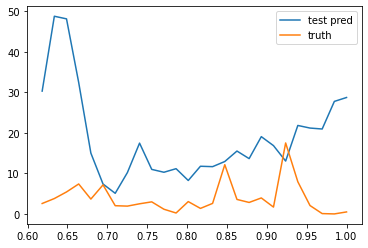

In [103]:
plt.plot(d[::43, 0], pred.loc, label='test pred')
plt.plot(d[::43, 0], a[::43], label='truth')
plt.legend()